In [ ]:
# default_exp model.learner

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_3321999/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Learner </center></h1>

In this module, we define the model architecture that we will use in our learner. It will be based on [`tsai`](https://github.com/timeseriesAI/tsai) models with a simple tweak: ability to handle categorical features.

The strategy to build our model is fairly simple:
+ apply a specific 'Embedding` layer to each categorical feature
+ concatenate the outcome of the embedding layers with the continuous features
+ pass the resulting tensor to a `tsai` existing model
The first 2 steps can be handled by the *head* of the network which can be seen as a layer.

Once the architecture defined, we can define our learner in the usual way and benefit from `fastai` training loop.

In [ ]:
# export
import os
import pickle
import warnings
from random import sample
from typing import List, Tuple

import numpy as np
import pandas as pd
import progressbar
from fastai.layers import trunc_normal_
from fastai.tabular.all import *
from fastai.text.all import *
from fastcore.basics import *

from footSeq.datastruct.core import *

In [ ]:
data_path = "./data"
target_data = pickle.load(open(os.path.join(data_path, "targets.pkl"), "rb"))
df_main = pd.read_pickle(os.path.join(data_path, "sequences_df.pkl")).reset_index()

In [ ]:
## available playing ids
seq_ids = L(set(df_main["_id"].tolist()) & set(target_data.keys()))
labels = L(target_data.values()).unique()

In [ ]:
lbl2ids = {l: L(k for k, v in target_data.items() if v == l) for l in labels}
ids2size = df_main.groupby("_id").size().to_dict()

In order to test our different examples, let's prepare a batch of data:

In [ ]:
cat_names = [
    "type_name",
    "bodypart_name",
    "play_pattern_name",
    "is_home",
    "under_pressure",
    "counterpress",
    "is_poss_team",
    "result_name",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

## splits
splits_ids = RandomSplitter()(seq_ids)

## fitst transform inspired from tabular pandas
procs = [Categorify, FillMissing, Normalize]
foot_tfm = FootSeqTransform(
    sequence_df=df_main,
    target_dict=target_data,
    ids=seq_ids,
    splits=splits_ids,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)

## to-tensor transform
to_tsr = FootSeqToTensor(cat_names, cont_names, max_len=10)

## tfmdlist
tls = TfmdLists(seq_ids, [foot_tfm, to_tsr], splits=splits_ids)

## datalodaers
train_seq_lens = L(min(ids2size[_id], 10) for _id in seq_ids[splits_ids[0]])
valid_seq_lens = L(min(ids2size[_id], 10) for _id in seq_ids[splits_ids[1]])


## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)

##sample a batch
srtd_batch = srtd_dls.one_batch()

srtd_batch

(tensor([[[ 6,  1,  3,  1,  1,  1,  2,  5],
          [15,  1,  3,  1,  1,  1,  2,  5],
          [ 6,  1,  3,  1,  1,  1,  2,  5],
          [15,  1,  3,  1,  1,  1,  2,  5],
          [ 6,  1,  3,  1,  1,  1,  2,  5],
          [15,  1,  3,  1,  1,  1,  2,  5],
          [ 6,  1,  3,  1,  1,  1,  2,  5],
          [15,  1,  3,  1,  1,  1,  2,  5],
          [ 6,  1,  3,  1,  1,  1,  2,  5],
          [15,  1,  3,  1,  1,  1,  2,  5]],
 
         [[15,  1,  6,  1,  1,  1,  2,  5],
          [15,  1,  6,  1,  1,  1,  2,  5],
          [15,  1,  6,  1,  1,  1,  2,  5],
          [ 6,  1,  6,  1,  1,  1,  2,  5],
          [15,  3,  6,  1,  1,  1,  2,  5],
          [ 6,  1,  6,  1,  2,  1,  2,  5],
          [15,  1,  6,  1,  2,  1,  2,  5],
          [ 6,  1,  6,  1,  2,  1,  2,  5],
          [15,  1,  6,  1,  2,  1,  2,  5],
          [15,  1,  6,  1,  1,  1,  2,  5]],
 
         [[15,  1,  7,  1,  1,  1,  2,  5],
          [ 6,  1,  7,  1,  1,  1,  2,  5],
          [15,  1,  7,  1,

# Model

## Embedding

In [ ]:
# export


@delegates()
class Embedding(nn.Embedding):
    """
    Embedding layer compatible with full pytorch API and truncated normal initialization

    Parameters
    ----------
    ni, nf: int
        input and output size of Embedding layer. It is the same
        as `num_embeddings` and `embedding_dim` in `torch.nn.Embedding()` module
    kwargs: dict
        Any argument accepted by `torch.nn.Embedding()` module
        a part from `num_embeddings` and `embedding_dim`
    std: float
        standard deviation applied in the truncated normal

    """

    def __init__(self, ni, nf, std=0.01, **kwargs):
        kwargs["num_embeddings"], kwargs["embedding_dim"] = ni, nf
        super().__init__(**kwargs)
        trunc_normal_(self.weight.data.cuda(), std=std)


class MultiEmbedding(Module):
    """
    Muti-dimesnion Embedding layer

    Attributes
    ----------
    cat_embed: torch.nn.ModuleList
        list of Embedding modules in the order in which categorical data appear

    """

    def __init__(
        self,
        n_embeds: List[int],
        embed_dims: List[int] = None,
        n_cont: int =0,
        std: float = 0.01,
        **kwargs
    ):
        """
        Initialise the various embedding sizes

        Parameters
        ----------
        n_embdes: List[int]
            length of the vocabulary of each categorical feature in the same order as passed in the tensor

        embed_dims: List[int]
            required size of each categorical feature embedding in the same order as passed in the tensor
            
        n_cont: int, optional
            number of continuous features

        std: float
            standard deviation applied in the truncated normal
        kwargs: dict
            extra parameters passed to the embedding layer. Should be
            compatible with `torch.nn.Embedding()`

        """
        assert n_cont >=0, "number of continuous features should be positive"
        self.n_cont = n_cont
        ## verify embedding size
        if embed_dims is None:
            embed_dims = [emb_sz_rule(s) for s in n_embeds]
        else:
            embed_dims = listify(embed_dims)
            if len(embed_dims) == 1:
                embed_dims = embed_dims * len(n_embeds)
            assert len(embed_dims) == len(n_embeds)

        self.cat_embed = nn.ModuleList(
            [
                Embedding(ni=n, nf=d, std=std, **kwargs)
                for n, d in zip(n_embeds, embed_dims)
            ]
        )

    def forward(self, x_cat, x_cont=None):
        x_cat = torch.cat([e(x_cat[..., i]) for i, e in enumerate(self.cat_embed)], -1)
        if self.n_cont != 0:
            x_cat = torch.cat([x_cat, x_cont], -1)
        return x_cat

In order to test this layer, we need to find the vocabulary size of each categorical variable and pass it in `n_embeds`:

In [ ]:
n_embeds = [len(tls.to.classes[n]) for n in tls.to.cat_names]
(tls.to.cat_names, n_embeds)

((#8) ['type_name','bodypart_name','play_pattern_name','is_home','under_pressure','counterpress','is_poss_team','result_name'],
 [22, 4, 10, 3, 3, 3, 3, 7])

Now let's initialize the layer and check that it works as expected:

In [ ]:
n_cont = srtd_batch[1].shape[-1]
multi_em = MultiEmbedding(n_embeds=n_embeds, n_cont=n_cont).cuda()
tsr_em = multi_em(srtd_batch[0], srtd_batch[1])
test_eq(
    tsr_em.shape[-1],
    L(w.weight.shape[-1] for w in multi_em.cat_embed).sum() + n_cont,
)

Now let's investigate how we can use the `padding_idx` option. This can be very useful to avoid training useless weight corresponding to padding values. Let's first create a batch with some padded values:

In [ ]:
reg_dls = tls.dataloaders(bs=5, before_batch=pad_seq)
padded_batch = reg_dls.one_batch()
padded_batch[0][0]

tensor([[ 6,  1,  9,  2,  1,  1,  2,  5],
        [15,  1,  9,  2,  1,  1,  2,  5],
        [ 6,  1,  9,  2,  1,  1,  2,  5],
        [15,  1,  9,  2,  1,  1,  2,  5],
        [ 6,  1,  9,  2,  1,  1,  2,  5],
        [15,  1,  9,  2,  1,  1,  2,  5],
        [ 6,  1,  9,  2,  1,  1,  2,  5],
        [15,  1,  9,  2,  1,  1,  2,  5],
        [ 6,  1,  9,  2,  1,  1,  2,  5],
        [15,  1,  9,  2,  1,  1,  2,  5]], device='cuda:0')

In [ ]:
multi_em_pad = MultiEmbedding(n_embeds, padding_idx=0, n_cont=n_cont).cuda()
tsr_em = multi_em_pad(padded_batch[0], padded_batch[1])
tsr_em[0]

tensor([[-0.5199, -1.4598,  1.4809, -0.5296, -1.4100,  2.5280,  0.5804, -0.9284,
          0.9980, -0.7382,  0.5828,  0.6865, -0.5352, -0.3123, -1.2477, -1.6916,
         -2.0771,  0.9703, -0.6094,  1.4018, -0.1036,  0.5364, -1.7615, -1.5067,
         -0.5230,  0.5667, -1.6076, -0.5847, -0.4096, -1.3761,  0.6366,  0.2417,
         -0.3364, -1.6510, -0.0459,  0.0501,  1.6502,  0.0491,  1.6745, -0.2641,
         -0.3553],
        [-0.1981,  1.0633,  0.9373, -1.5942,  0.1827, -0.7031,  0.0292, -0.7047,
          0.1495, -0.7382,  0.5828,  0.6865, -0.5352, -0.3123, -1.2477, -1.6916,
         -2.0771,  0.9703, -0.6094,  1.4018, -0.1036,  0.5364, -1.7615, -1.5067,
         -0.5230,  0.5667, -1.6076, -0.5847, -0.4096, -1.3761,  0.6366,  0.2417,
         -0.3364, -1.6510, -0.0459,  0.0501,  1.6502, -0.1199,  1.1134, -0.2628,
         -0.2878],
        [-0.5199, -1.4598,  1.4809, -0.5296, -1.4100,  2.5280,  0.5804, -0.9284,
          0.9980, -0.7382,  0.5828,  0.6865, -0.5352, -0.3123, -1.2477,

Notice how the dimension with all zeros (the default padding index) are also filled in with all zeros in the resulting tensor.

## Full Architecture

Now we are ready to plug in the embedding to any `tsai` learner. Our architecture is fairly straightforward:
+ `head` is the head of the network and runs the data through the `multiEmbedding` layer
+ `body` takes the output of `head` and run it through the desired architecture selected by the user in `ts_arch`

In [ ]:
#export

@delegates(MultiEmbedding.__init__)
class footSeqModel(Module):
    "Sequence model with an embedding head."

    def __init__(self, ts_arch: Module, n_cont: int, c_out: int, ts_kwargs, **kwargs):
        """
        Intialise the model architecture

        Parameters
        ----------
        ts_arch: Module
            one of tsai Model architectures
        ts_kwargs: dict
            any of the inputs accepted by the selected architecture a part from `c_out`
        c_out: int
            number of output layers
        n_cont: int
            number of continuous features
        kwarsgs: dict
            all parameters accepted by the `MultiEmbedding` layer

        """
        ## head of the network
        kwargs["n_cont"] = n_cont
        self.head = MultiEmbedding(**kwargs)
        
        ## inialise the body
        self.c_out, self.n_cont = c_out, n_cont
        self.c_in = L(w.weight.shape[-1] for w in self.head.cat_embed).sum() + n_cont
        ts_kwargs["c_in"], ts_kwargs["c_out"] = self.c_in, self.c_out
        self.body = ts_arch(**ts_kwargs)
        

    def forward(self, x_cat, x_cont):
        ## run through head first
        x = self.head(x_cat, x_cont)
        
        return self.body(x.transpose(2, 1))

In [ ]:
from tsai.models.RNN import *

n_cont = padded_batch[1].shape[-1]
ts_model = LSTM
ts_args = {"n_layers":2, "bidirectional":True}
model = footSeqModel(ts_arch=ts_model, n_cont=n_cont, c_out=2, ts_kwargs=ts_args, n_embeds=n_embeds).cuda()
model

footSeqModel(
  (head): MultiEmbedding(
    (cat_embed): ModuleList(
      (0): Embedding(22, 9)
      (1): Embedding(4, 3)
      (2): Embedding(10, 6)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(3, 3)
      (7): Embedding(7, 5)
    )
  )
  (body): LSTM(
    (rnn): LSTM(41, 100, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [ ]:
model(padded_batch[0], padded_batch[1])

tensor([[ 0.0375,  0.0235],
        [-0.0329,  0.0624],
        [ 0.0071,  0.0449],
        [ 0.0592,  0.0041],
        [-0.0337,  0.0609]], device='cuda:0', grad_fn=<AddmmBackward>)

# Learner

Defining a learner at this stage is straightforward, we just need to decide on the appropriate loss function to use, pass the `dataloaders` and the metrics we want to track:

SuggestedLRs(valley=0.002511886414140463)

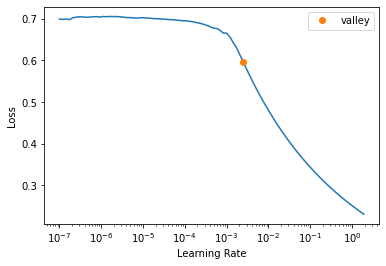

In [ ]:
from fastai.metrics import *
learn = Learner(srtd_dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
